<a href="https://colab.research.google.com/github/LeeYoungWook/dd/blob/master/%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **오토인코더**

오토인코더 : 오토엔코더는 입력데이터를  집어넣어서 나오는 출력이 입력데이터의 근사를 갖는 비지도 학습이다.


![대체 텍스트](https://github.com/LeeYoungWook/dd/blob/master/%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94.PNG?raw=true)

-인코더: 입력 데이터를 표현할 수 있는 핵심 특징으로 압축시킨다. 

-디코더: 인코더에서 압축된 핵심 특징을 다시 디코더 부분에서 입력 데이터와 동일하게 복원시킨다.






In [51]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

# 하이퍼파라미터
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [0]:
trainset = datasets.MNIST(root='./data/', train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [0]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),   # 입력의 특징을 3차원으로 압축합니다
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # 픽셀당 0과 1 사이로 값을 출력합니다
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [0]:

# 원본 이미지를 시각화 하기 (첫번째 열)
view_data = trainset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.

In [0]:
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

[Epoch 1]


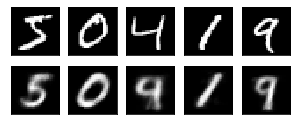

[Epoch 2]


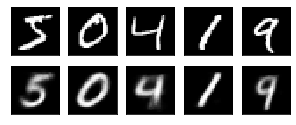

[Epoch 3]


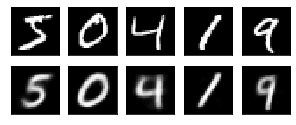

[Epoch 4]


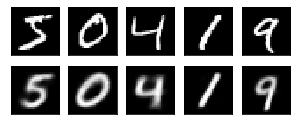

[Epoch 5]


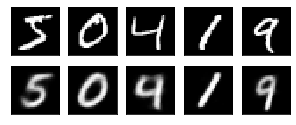

[Epoch 6]


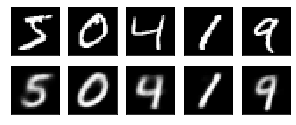

[Epoch 7]


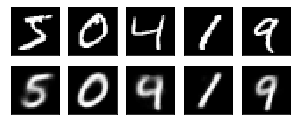

[Epoch 8]


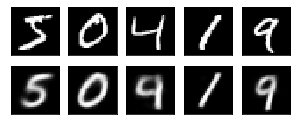

[Epoch 9]


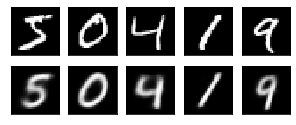

[Epoch 10]


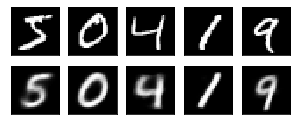

In [56]:
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

    # 디코더에서 나온 이미지를 시각화 하기 (두번째 열)
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    # 원본과 디코딩 결과 비교해보기
    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28, 28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

In [57]:
from torchsummary import summary
summary(autoencoder, (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]         100,480
              ReLU-2               [-1, 1, 128]               0
            Linear-3                [-1, 1, 64]           8,256
              ReLU-4                [-1, 1, 64]               0
            Linear-5                [-1, 1, 12]             780
              ReLU-6                [-1, 1, 12]               0
            Linear-7                 [-1, 1, 3]              39
            Linear-8                [-1, 1, 12]              48
              ReLU-9                [-1, 1, 12]               0
           Linear-10                [-1, 1, 64]             832
             ReLU-11                [-1, 1, 64]               0
           Linear-12               [-1, 1, 128]           8,320
             ReLU-13               [-1, 1, 128]               0
           Linear-14               [-1,

In [58]:
sum([param.nelement() for param in autoencoder.parameters()])

219891

In [59]:
print(autoencoder)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


**잠재변수 들여다보기**

In [0]:
# 잠재변수를 3D 플롯으로 시각화
view_data = trainset.data[:200].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to("cpu")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Attempting to set identical left == right == -0.03257707506418228 results in singular transformations; automatically expanding.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Attempting to set identical bottom == top == -0.13928329944610596 results in singular transformations; automatically expanding.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Attempting to set identical bottom == top == -0.2919735610485077 results in singular transformations; automatically expanding.


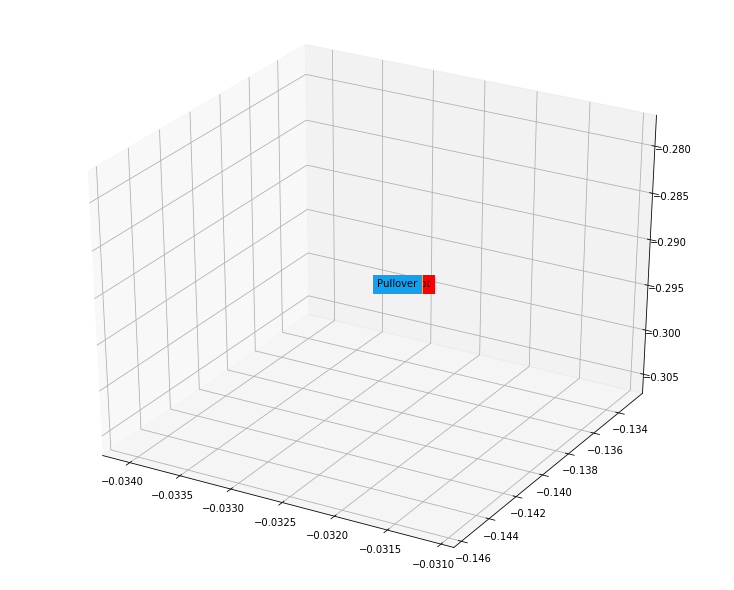

In [74]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()
Z = encoded_data.data[:, 2].numpy()

labels = trainset.targets[:200].numpy()

for x, y, z, s in zip(X, Y, Z, labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x, y, z, name, backgroundcolor=color)

ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()

# **잡음 제거 오토인코더**

입력된 데이터의 정보를 유지하면서 보다 좋은 특징 을 추출할 뿐만 아니
라, 입력에 포함된 잡음을 제거하는 역할을한다.

![대체 텍스트](https://github.com/LeeYoungWook/dd/blob/master/qqqqq.PNG?raw=true)

In [0]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
import numpy as np

In [114]:
# 하이퍼파라미터
EPOCH = 30
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", DEVICE)

다음 기기로 학습합니다: cuda


In [0]:
testset = datasets.MNIST(root='./data/', train=False, download=True, transform=transforms.ToTensor())

In [116]:
def add_noise(img):
  noise = torch.randn(img.size()) * 0.2
  noisy_img = img + noise
  return noisy_img

def train(autoencoder, train_loader):
  autoencoder.train()
  avg_loss = 0
  for step, (x, label) in enumerate(train_loader):
    x = add_noise(x)
    x = x.view(-1, 28*28).to(DEVICE)
    y = x.view(-1, 28*28).to(DEVICE)
    label = label.to(DEVICE)

    encoded, decoded = autoencoder(x)

    loss = criterion(decoded, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    avg_loss += loss.item()
  return avg_loss / len(train_loader)

for epoch in range(1, EPOCH+1):
  loss = train(autoencoder, train_loader)
  print('[Epoch {}] loss:{}'.format(epoch, loss))

[Epoch 1] loss:0.07170143545563541
[Epoch 2] loss:0.07170420930361443
[Epoch 3] loss:0.07164698075860548
[Epoch 4] loss:0.07176762926521332
[Epoch 5] loss:0.0716468289272109
[Epoch 6] loss:0.0717139879841286
[Epoch 7] loss:0.07161296899321237
[Epoch 8] loss:0.07162193899978199
[Epoch 9] loss:0.0715008467308748
[Epoch 10] loss:0.07152795909183111
[Epoch 11] loss:0.07147947620195366
[Epoch 12] loss:0.0715965343786201
[Epoch 13] loss:0.07150079529962815
[Epoch 14] loss:0.07148883090630523
[Epoch 15] loss:0.07161677152966894
[Epoch 16] loss:0.07149188415105663
[Epoch 17] loss:0.07149515510685663
[Epoch 18] loss:0.07139966265161408
[Epoch 19] loss:0.0714518080260962
[Epoch 20] loss:0.07145778876917958
[Epoch 21] loss:0.07158902208052718
[Epoch 22] loss:0.07156601114504373
[Epoch 23] loss:0.07134595815179699
[Epoch 24] loss:0.07132503921702218
[Epoch 25] loss:0.07129907813757214
[Epoch 26] loss:0.07143615488050335
[Epoch 27] loss:0.07145253986692124
[Epoch 28] loss:0.07134513372678493
[Epoch


**이미지 복원 시각화 하기**

In [0]:
sample_data = testset.data[0].view(-1,28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.

In [0]:
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x)

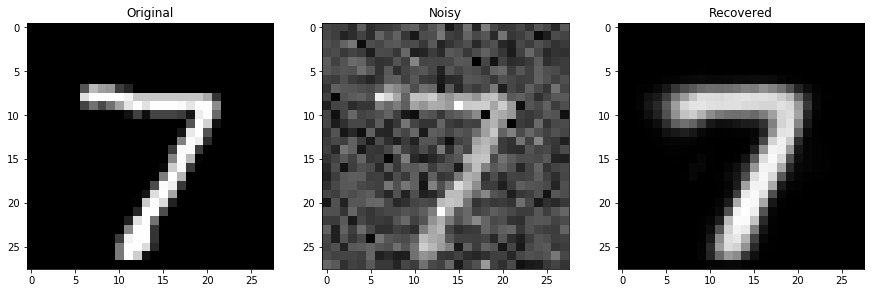

In [119]:
f, a = plt.subplots(1, 3, figsize=(15,15))

original_img = np.reshape(original_x.to('cpu').data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to('cpu').data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to('cpu').data.numpy(), (28, 28))

a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()

In [128]:
from torchsummary import summary
summary( autoencoder.train(), (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]         100,480
              ReLU-2               [-1, 1, 128]               0
            Linear-3                [-1, 1, 64]           8,256
              ReLU-4                [-1, 1, 64]               0
            Linear-5                [-1, 1, 12]             780
              ReLU-6                [-1, 1, 12]               0
            Linear-7                 [-1, 1, 3]              39
            Linear-8                [-1, 1, 12]              48
              ReLU-9                [-1, 1, 12]               0
           Linear-10                [-1, 1, 64]             832
             ReLU-11                [-1, 1, 64]               0
           Linear-12               [-1, 1, 128]           8,320
             ReLU-13               [-1, 1, 128]               0
           Linear-14               [-1,

In [121]:
sum([param.nelement() for param in autoencoder.parameters()])

219891

In [122]:
print(autoencoder)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)
